# Simulation 18 - Plotting NS3 Results

TJ Kim
5/13/21

Take txt files from Sandesh and plot.

In [42]:
from IPython.core.debugger import set_trace

# Import Generic Classes
import numpy as np
import copy
import pickle
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab



# Import All Custom Classes
import os, sys
sys.path.append(os.path.pardir+"/classes")
sys.path.append(os.path.pardir+"/solvers")
sys.path.append(os.path.pardir+"/one_mobility")
sys.path.append(os.path.curdir + "/sim_store/sim9")


from Server import *
from User import *
from Link import *
from Job import *
from Migration_Plans import *
from Cost_Recordings import *

# Import Solver Classes
from Optim_PlanGenerator import *
from SeqGreedy_PlanGenerator import *
from Myopic_PlanGenerator import *
from Naive_PlanGenerator import *
from Cloud_PlanGenerator import *

import itertools

### Polish data loaded from files

(latencyms_moveh_trial) is the file name type.
Make a CDF plot for each of the latency times and on each plot have all move_h averaged across all trials.

In [119]:
path = '/home/tkim/Academics/MEC_python/simulations/sim_store/sim18/VM-migration/'

trials = 10
ms_vals = ['20','40','60','100']
h_vals = ['20','40','60','80']

store = {}


for ms,h in itertools.product(ms_vals,h_vals):

    times = []
    
    for i in range(trials):
    
        try:
            with open(path + ms+'ms_' + h + 'h_' + str(i+1), 'r') as infile:
                data = infile.readlines()
                for i in data:
                    line = i.split()
                    try:
                        if line[0] == '64':
                            times += [line[6][5:]]
                    except:
                        continue
        except:
            continue

        
    times = np.asarray(times)
    idxs = np.argwhere(times!='')
    
    times = times[idxs]
    times = times.astype(float)
    store[ms+'ms_'+h+'h'] = times

### Find means and Add noise

In [120]:
thresh = 3
data = {}

for ms in ms_vals:
    data[ms+"ms"] = {}
    for h in h_vals:
        temp_data = store[ms+'ms_'+h+'h']
        temp_data = temp_data[temp_data<thresh * np.mean(temp_data)]
        print("\n"+h+"h"+ ms +"ms Mean:", np.mean(temp_data))
        print(h+"h"+ ms +"ms Max:", np.max(temp_data))
        print(h+"h"+ ms +"ms min:", np.min(temp_data))
        
        # Edit data based on max value
        
        
        data[ms+"ms"][h+"h"] = temp_data
        


20h20ms Mean: 75.1500883392226
20h20ms Max: 148.0
20h20ms min: 26.5

40h20ms Mean: 68.01753764393268
40h20ms Max: 157.0
40h20ms min: 23.6

60h20ms Mean: 62.915217391304346
60h20ms Max: 149.0
60h20ms min: 25.4

80h20ms Mean: 66.94953191489361
80h20ms Max: 151.0
80h20ms min: 28.1

20h40ms Mean: 95.83215725806451
20h40ms Max: 394.0
20h40ms min: 26.6

40h40ms Mean: 81.82968609865472
40h40ms Max: 189.0
40h40ms min: 25.4

60h40ms Mean: 68.71983842010772
60h40ms Max: 166.0
60h40ms min: 24.7

80h40ms Mean: 64.13779119930976
80h40ms Max: 144.0
80h40ms min: 26.1

20h60ms Mean: 118.97987477638641
20h60ms Max: 295.0
20h60ms min: 25.9

40h60ms Mean: 98.44164456233422
40h60ms Max: 299.0
40h60ms min: 24.7

60h60ms Mean: 76.49531388152077
60h60ms Max: 235.0
60h60ms min: 24.9

80h60ms Mean: 69.90398886827458
80h60ms Max: 150.0
80h60ms min: 32.1

20h100ms Mean: 166.3339670468948
20h100ms Max: 405.0
20h100ms min: 26.2

40h100ms Mean: 133.0157193605684
40h100ms Max: 385.0
40h100ms min: 0.0

60h100ms Mean

### Make CDF and Plot All Data

Loop through all the MS and plot different H values together.
Next we will threshold the data.

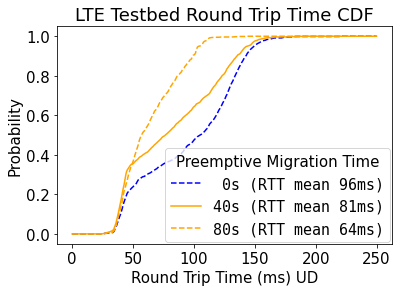

In [134]:
from matplotlib.pyplot import figure

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# How many data points in CDF
granular = 300
ms_vals = ['40']

for ms in ms_vals:
    data_20 = data[ms+"ms"]["20h"]
    data_40 = data[ms+"ms"]["40h"]
    data_60 = data[ms+"ms"]["60h"]
    data_80 = data[ms+"ms"]["80h"]
    
    data_naive = np.empty(0)
    data_0 = np.empty(0)
    # Alternate Density -Naive- 
    for i in range(trials):
        data_naive = np.append(data_naive,data_20[20+i*120:80+i*120])
        data_0 = np.append(data_0,data_20[20+i*120:120+i*120])
        
    # Add noise to all data ~ avg 5
        
    
    # Find max
    a1 = np.append(data_20,data_40)
    a2 = np.append(data_60,data_80)
    thresh_true = 250 # np.max(np.append(a1,a2))
    
    xs = np.linspace(0.1,thresh_true,granular)
    
    # d_naive
    dn_density = stats.gaussian_kde(data_naive)
    dn_xs = xs
    dn_density.covariance_factor = lambda : 0.01
    dn_density._compute_covariance()
    dx = dn_xs[1]-dn_xs[0]
    dn_data = dn_density(dn_xs)
    dn_data /= (dx * dn_data).sum()
    dn_cdf = np.cumsum(dn_data* (dx))
    
    # d0
    d0_density = stats.gaussian_kde(data_0)
    d0_xs = xs
    d0_density.covariance_factor = lambda : 0.01
    d0_density._compute_covariance()
    dx = d0_xs[1]-d0_xs[0]
    d0_data = d0_density(d0_xs)
    d0_data /= (dx * d0_data).sum()
    d0_cdf = np.cumsum(d0_data* (dx))
    
    # d40
    d40_density = stats.gaussian_kde(data_40)
    d40_xs = xs
    d40_density.covariance_factor = lambda : 0.01
    d40_density._compute_covariance()
    dx = d40_xs[1]-d40_xs[0]
    d40_data = d40_density(d40_xs)
    d40_data /= (dx * d40_data).sum()
    d40_cdf = np.cumsum(d40_data* (dx))
    
    # d60
    d60_density = stats.gaussian_kde(data_60)
    d60_xs = xs
    d60_density.covariance_factor = lambda : 0.01
    d60_density._compute_covariance()
    dx = d60_xs[1]-d60_xs[0]
    d60_data = d60_density(d60_xs)
    d60_data /= (dx * d60_data).sum()
    d60_cdf = np.cumsum(d60_data* (dx))
    
    # d80
    d80_density = stats.gaussian_kde(data_80)
    d80_xs = xs
    d80_density.covariance_factor = lambda : 0.01
    d80_density._compute_covariance()
    dx = d80_xs[1]-d80_xs[0]
    d80_data = d80_density(d80_xs)
    d80_data /= (dx * d80_data).sum()
    d80_cdf = np.cumsum(d80_data* (dx))
    
    # Set Font Size Limitations
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)
    
    plt.figure()#figsize=(7, 4))

    # Plot CDF
    #plt.plot(dn_xs, dn_cdf, label = "No Mig. (RTT mean " + str(np.mean(data_naive))[0:2] + "ms)", color = 'blue')
    plt.plot(d0_xs, d0_cdf, label = " 0s (RTT mean " + str(np.mean(data_0))[0:2] + "ms)", color = 'blue', linestyle='dashed')
    plt.plot(d40_xs, d40_cdf, label = "40s (RTT mean " + str(np.mean(data_40))[0:2] + "ms)", color = 'orange')
    plt.plot(d80_xs, d80_cdf, label = "80s (RTT mean " + str(np.mean(data_80))[0:2] + "ms)", color = 'orange', linestyle='dashed')
    # plt.xscale('log')

    plt.ylabel('Probability')
    plt.title('LTE Testbed Round Trip Time CDF')
    plt.xlabel('Round Trip Time (ms) UD')
    plt.legend(borderaxespad=0.1,loc = "lower right",prop={'family': 'DejaVu Sans Mono'}, title='Preemptive Migration Time')


    # plt.ylim(-.3,1)
    plt.show()

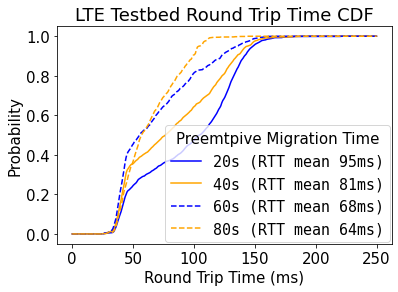

In [117]:
from matplotlib.pyplot import figure

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# How many data points in CDF
granular = 300
ms_vals = ['40']

for ms in ms_vals:
    data_20 = data[ms+"ms"]["20h"]
    data_40 = data[ms+"ms"]["40h"]
    data_60 = data[ms+"ms"]["60h"]
    data_80 = data[ms+"ms"]["80h"]
    
    # Find max
    a1 = np.append(data_20,data_40)
    a2 = np.append(data_60,data_80)
    thresh_true = 250 # np.max(np.append(a1,a2))
    
    xs = np.linspace(0.1,thresh_true,granular)
    
    # d20
    d20_density = stats.gaussian_kde(data_20)
    d20_xs = xs
    d20_density.covariance_factor = lambda : 0.01
    d20_density._compute_covariance()
    dx = d20_xs[1]-d20_xs[0]
    d20_data = d20_density(d20_xs)
    d20_data /= (dx * d20_data).sum()
    d20_cdf = np.cumsum(d20_data* (dx))
    
    # d40
    d40_density = stats.gaussian_kde(data_40)
    d40_xs = xs
    d40_density.covariance_factor = lambda : 0.01
    d40_density._compute_covariance()
    dx = d40_xs[1]-d40_xs[0]
    d40_data = d40_density(d40_xs)
    d40_data /= (dx * d40_data).sum()
    d40_cdf = np.cumsum(d40_data* (dx))
    
    # d60
    d60_density = stats.gaussian_kde(data_60)
    d60_xs = xs
    d60_density.covariance_factor = lambda : 0.01
    d60_density._compute_covariance()
    dx = d60_xs[1]-d60_xs[0]
    d60_data = d60_density(d60_xs)
    d60_data /= (dx * d60_data).sum()
    d60_cdf = np.cumsum(d60_data* (dx))
    
    # d80
    d80_density = stats.gaussian_kde(data_80)
    d80_xs = xs
    d80_density.covariance_factor = lambda : 0.01
    d80_density._compute_covariance()
    dx = d80_xs[1]-d80_xs[0]
    d80_data = d80_density(d80_xs)
    d80_data /= (dx * d80_data).sum()
    d80_cdf = np.cumsum(d80_data* (dx))
    
    # Set Font Size Limitations
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)
    
    plt.figure()#figsize=(7, 4))

    # Plot CDF
    plt.plot(d20_xs, d20_cdf, label = "20s (RTT mean " + str(np.mean(data_20))[0:2] + "ms)", color = 'blue')
    plt.plot(d40_xs, d40_cdf, label = "40s (RTT mean " + str(np.mean(data_40))[0:2] + "ms)", color = 'orange')
    plt.plot(d60_xs, d60_cdf, label = "60s (RTT mean " + str(np.mean(data_60))[0:2] + "ms)", color = 'blue', linestyle='dashed')
    plt.plot(d80_xs, d80_cdf, label = "80s (RTT mean " + str(np.mean(data_80))[0:2] + "ms)", color = 'orange', linestyle='dashed')
    # plt.xscale('log')

    plt.ylabel('Probability')
    plt.title('LTE Testbed Round Trip Time CDF')
    plt.xlabel('Round Trip Time (ms)')
    plt.legend(borderaxespad=0.1,loc = "lower right",prop={'family': 'DejaVu Sans Mono'}, title='Preemtpive Migration Time')


    # plt.ylim(-.3,1)
    plt.show()

In [123]:
data_20.shape

(992,)

In [124]:
    data_naive = np.empty(0)


In [127]:
data_naive

array([93.40, 139.00, 134.00, 120.00, 101.00, 133.00, 115.00, 130.00,
       151.00, 150.00, 123.00, 133.00, 133.00, 139.00, 126.00, 126.00,
       129.00, 159.00, 150.00, 139.00, 146.00, 112.00, 131.00, 149.00,
       123.00, 146.00, 114.00, 129.00, 135.00, 113.00, 144.00, 119.00,
       128.00, 117.00, 155.00, 134.00, 138.00, 144.00, 118.00, 124.00,
       115.00, 138.00, 123.00, 118.00, 130.00, 117.00, 107.00, 112.00,
       124.00, 124.00, 117.00, 105.00, 118.00, 110.00, 104.00, 135.00,
       103.00, 98.70, 101.00, 122.00, 130.00, 136.00, 113.00, 116.00,
       134.00, 103.00, 139.00, 123.00, 141.00, 140.00, 138.00, 128.00,
       144.00, 134.00, 108.00, 120.00, 109.00, 101.00, 110.00, 124.00,
       148.00, 137.00, 160.00, 125.00, 142.00, 128.00, 121.00, 136.00,
       136.00, 111.00, 105.00, 108.00, 130.00, 153.00, 125.00, 134.00,
       120.00, 113.00, 120.00, 126.00, 127.00, 106.00, 112.00, 135.00,
       110.00, 132.00, 129.00, 145.00, 123.00, 131.00, 133.00, 128.00,
       1